In [174]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt 
import random 
import math
import numpy as np

In [175]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [176]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)

In [177]:
# build the dataset
random.shuffle(words)
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1

X, Y = torch.tensor(X), torch.tensor(Y)

In [178]:
# data set splits 80%, 10%, 10%
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

In [179]:
device = "cpu"

In [180]:
n_embd = 10 # dim of the character embedding vector
n_hidden = 100 # the # of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

class MLP(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, vocab_size, bias=False)
        )

    def forward(self, x):
        logits = self.linear_tanh_stack(x)
        return logits

In [181]:
model = MLP(vocab_size=vocab_size, n_embd=n_embd).to(device)
print(model)

MLP(
  (linear_tanh_stack): Sequential(
    (0): Embedding(27, 10)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=30, out_features=100, bias=False)
    (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=100, bias=False)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=100, bias=False)
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Linear(in_features=100, out_features=100, bias=False)
    (12): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Tanh()
    (14): Linear(in_features=100, out_features=27, bias=False)
  )
)


In [182]:
losses, inxs = [], []
loss_function = nn.CrossEntropyLoss()
weight_decay = 1e-3
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
steps = 100000
model.train()
for epoch in range(steps):
    inx = torch.randint(0, training_set.shape[0], (64,), generator=g)
    emb = training_set[inx] # grab only those rows from the minibatch 

    optimizer.zero_grad()

    # forward pass
    preds = model(emb)
    loss = loss_function(preds, y_training_set[inx])

    # backward pass
    loss.backward()

    # update the weights
    optimizer.step()

    #stats
    if epoch % 1000 == 0: # print every once in a while
        print(f'{epoch:7d}/{steps:7d}: {loss.item():.4f}')
    losses.append(loss.item())
    inxs.append(epoch)
   
loss

      0/ 100000: 3.3443


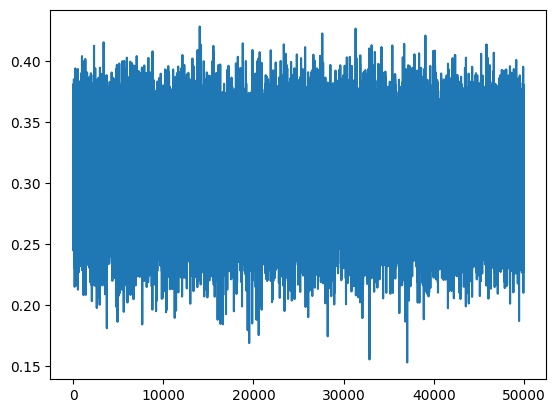

In [ ]:
# plot loss
plt.plot(inxs, np.log10(losses))
# plt.xscale("log")

In [ ]:
# sample from the model
@torch.no_grad()
def sample(model):
	g = torch.Generator().manual_seed(2147483647 + 10)
	model.eval()
	for _ in range(20):
		out = '.' * block_size
		while True:
			x = torch.tensor([str_to_inx[x] for x in out[-block_size:]])
			x = x.view(1, -1)
			logits = model(x)
			probs = F.softmax(logits, dim=1)
			inx = torch.multinomial(probs, num_samples=1, generator=g).item()
			out = out + inx_to_str[inx]
			if inx == 0:
				break
		
		print(out.replace('.', ''))
sample(model)

carmah
amelle
khyrir
xie
tyrencessa
jazonel
delynn
jareei
nellara
chaiir
kaleigh
ham
join
quint
sulie
alianni
waterri
jarynix
kael
dusai


In [ ]:
@torch.no_grad() # disable gradient tracking
def get_loss(model, data_set):
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    model.eval()

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(data_set, loss.item())

get_loss(model,'train')
get_loss(model,'dev')

train 2.0144202709198
dev 2.092857599258423
